In [1]:
!pip install -q timm einops
!pip install -q rouge-score
!pip install -q flash_attn
!pip install -q transformers==4.37.2
!wget https://github.com/Dao-AILab/flash-attention/releases/download/v2.6.3/flash_attn-2.6.3+cu123torch2.4cxx11abiFALSE-cp310-cp310-linux_x86_64.whl
!pip install -q --no-dependencies --upgrade flash_attn-2.6.3+cu123torch2.4cxx11abiFALSE-cp310-cp310-linux_x86_64.whl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 51.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 70.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 88.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not cu

In [2]:
import os
import numpy as np
import torch
import torchvision.transforms as T
# from decord import VideoReader, cpu
from PIL import Image
from torchvision.transforms.functional import InterpolationMode
from transformers import AutoModel, AutoTokenizer
import matplotlib.pyplot as plt
import glob
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.tokenize import word_tokenize
from rouge_score import rouge_scorer
import torch
from PIL import Image
import pandas as pd

In [3]:
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

def build_transform(input_size):
    MEAN, STD = IMAGENET_MEAN, IMAGENET_STD
    transform = T.Compose([
        T.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),
        T.Resize((input_size, input_size), interpolation=InterpolationMode.BICUBIC),
        T.ToTensor(),
        T.Normalize(mean=MEAN, std=STD)
    ])
    return transform

def find_closest_aspect_ratio(aspect_ratio, target_ratios, width, height, image_size):
    best_ratio_diff = float('inf')
    best_ratio = (1, 1)
    area = width * height
    for ratio in target_ratios:
        target_aspect_ratio = ratio[0] / ratio[1]
        ratio_diff = abs(aspect_ratio - target_aspect_ratio)
        if ratio_diff < best_ratio_diff:
            best_ratio_diff = ratio_diff
            best_ratio = ratio
        elif ratio_diff == best_ratio_diff:
            if area > 0.5 * image_size * image_size * ratio[0] * ratio[1]:
                best_ratio = ratio
    return best_ratio

def dynamic_preprocess(image, min_num=1, max_num=12, image_size=448, use_thumbnail=False):
    orig_width, orig_height = image.size
    aspect_ratio = orig_width / orig_height

    # calculate the existing image aspect ratio
    target_ratios = set(
        (i, j) for n in range(min_num, max_num + 1) for i in range(1, n + 1) for j in range(1, n + 1) if
        i * j <= max_num and i * j >= min_num)
    target_ratios = sorted(target_ratios, key=lambda x: x[0] * x[1])

    # find the closest aspect ratio to the target
    target_aspect_ratio = find_closest_aspect_ratio(
        aspect_ratio, target_ratios, orig_width, orig_height, image_size)

    # calculate the target width and height
    target_width = image_size * target_aspect_ratio[0]
    target_height = image_size * target_aspect_ratio[1]
    blocks = target_aspect_ratio[0] * target_aspect_ratio[1]

    # resize the image
    resized_img = image.resize((target_width, target_height))
    processed_images = []
    for i in range(blocks):
        box = (
            (i % (target_width // image_size)) * image_size,
            (i // (target_width // image_size)) * image_size,
            ((i % (target_width // image_size)) + 1) * image_size,
            ((i // (target_width // image_size)) + 1) * image_size
        )
        # split the image
        split_img = resized_img.crop(box)
        processed_images.append(split_img)
    assert len(processed_images) == blocks
    if use_thumbnail and len(processed_images) != 1:
        thumbnail_img = image.resize((image_size, image_size))
        processed_images.append(thumbnail_img)
    return processed_images

def load_image(image_file, input_size=448, max_num=12):
    image = Image.open(image_file).convert('RGB')
    transform = build_transform(input_size=input_size)
    images = dynamic_preprocess(image, image_size=input_size, use_thumbnail=True, max_num=max_num)
    pixel_values = [transform(image) for image in images]
    pixel_values = torch.stack(pixel_values)
    return pixel_values

In [4]:
model_name = "5CD-AI/Vintern-1B-v2"

In [5]:
try:
  model = AutoModel.from_pretrained(
      model_name,
      torch_dtype=torch.bfloat16,
      low_cpu_mem_usage=True,
      trust_remote_code=True,
      use_flash_attn=False,
  ).eval().cuda()
except:
  model = AutoModel.from_pretrained(
      model_name,
      torch_dtype=torch.bfloat16,
      low_cpu_mem_usage=True,
      trust_remote_code=True
  ).eval().cuda()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/5.33k [00:00<?, ?B/s]

configuration_internvl_chat.py:   0%|          | 0.00/3.80k [00:00<?, ?B/s]

configuration_intern_vit.py:   0%|          | 0.00/5.55k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/5CD-AI/Vintern-1B-v2:
- configuration_intern_vit.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/5CD-AI/Vintern-1B-v2:
- configuration_internvl_chat.py
- configuration_intern_vit.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_internvl_chat.py:   0%|          | 0.00/15.2k [00:00<?, ?B/s]

conversation.py:   0%|          | 0.00/15.8k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/5CD-AI/Vintern-1B-v2:
- conversation.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_intern_vit.py:   0%|          | 0.00/18.2k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/5CD-AI/Vintern-1B-v2:
- modeling_intern_vit.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/5CD-AI/Vintern-1B-v2:
- modeling_internvl_chat.py
- conversation.py
- modeling_intern_vit.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated 

model.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/69.0 [00:00<?, ?B/s]

In [6]:
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True, use_fast=False)

tokenizer_config.json:   0%|          | 0.00/3.02k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/3.38M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/265 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [7]:
df_test = pd.read_csv("/kaggle/input/data-nlp-bai-2/df_test.csv")
df_test = df_test.iloc[:50]
df_test

,index,image_id,question,answer,image_path
0,95956,10757,để đo_suất điện_động e và điện trở trong r của...,mắc vôn_kế v vào hai đầu đoạn mạch mn là phươn...,/kaggle/input/data-nlp-bai-2/img/img/10757.jpg
1,47881,27595,vì sao gia_súc ăn cỏ được nuôi nhiều ở khu_vực...,gia_súc ăn cỏ được nuôi phổ_biến ở nơi có nhiề...,/kaggle/input/data-nlp-bai-2/img/img/27595.jpg
2,142,12035,trong bảng của bài_toán số 2 cột 1 thể_hiện đơ...,cột 1 của bảng trong bài_toán số 2 sử_dụng đơn...,/kaggle/input/data-nlp-bai-2/img/img/12035.jpg
3,80956,46219,yếu_tố kinh_tế xã_hội nào ảnh_hưởng trực_tiếp ...,yếu_tố kinh_tế xã_hội ảnh_hưởng trực_tiếp đến ...,/kaggle/input/data-nlp-bai-2/img/img/46219.jpg
4,230685,40167,văn_bản có đề_cập đến những khó_khăn nào mà ng...,văn_bản đề_cập đến những khó_khăn mà người_dân...,/kaggle/input/data-nlp-bai-2/img/img/40167.jpg
5,248671,49776,theo nội_dung phần ghi_nhớ đầu_tiên thành_ngữ ...,thành_ngữ được định_nghĩa_là loại cụm_từ có cấ...,/kaggle/input/data-nlp-bai-2/img/img/49776.jpg
6,188446,31714,sản_lượng sản_xuất than của liên_xô vào năm 19...,sản_lượng sản_xuất than của liên_xô vào năm 19...,/kaggle/input/data-nlp-bai-2/img/img/31714.jpg
7,93533,6711,nội_dung của câu hỏi được in đậm ở góc trên bê...,câu hỏi được in đậm ở góc trên bên phải là nếu...,/kaggle/input/data-nlp-bai-2/img/img/6711.jpg
8,75309,45088,số 3 ở cuối bức ảnh có ý_nghĩa gì,số 3 ở cuối bức ảnh có_thể là số trang của cuố...,/kaggle/input/data-nlp-bai-2/img/img/45088.jpg
9,235574,41145,theo phần em có biết động_vật giáp xác có vai_...,theo phần em có biết động_vật giáp xác tôm nhỏ...,/kaggle/input/data-nlp-bai-2/img/img/41145.jpg


In [8]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.tokenize import word_tokenize
from rouge_score import rouge_scorer
import torch
from PIL import Image

# Download required NLTK data
nltk.download('punkt')

# Initialize lists to store scores
bleu_scores = []
rouge1_scores = []
rouge2_scores = []
rougeL_scores = []

# Initialize ROUGE scorer
rouge_scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

for index, row in df_test.iterrows():
    image_id = row['image_id']
    question = row['question'].replace('_', ' ').lower()
    expected_answer = row['answer']

    test_image = f"/kaggle/input/data-nlp-bai-2/img/img/{image_id}.jpg"

    # Load and process image
    pixel_values = load_image(test_image, max_num=6).to(torch.bfloat16).cuda()
    generation_config = dict(max_new_tokens=512, do_sample=False, num_beams=3, repetition_penalty=3.5)

    # Generate response
    response = model.chat(tokenizer, pixel_values, question, generation_config)
    response = response.replace("'", "").replace("[", "").replace("]", "").replace("_", " ").lower()

    # Tokenize texts
    reference = [word_tokenize(expected_answer.lower())]
    hypothesis = word_tokenize(response.lower())
    reference_str = expected_answer.lower().replace('_', ' ').lower()
    hypothesis_str = response.lower().replace('_', ' ').lower()

    # Calculate BLEU score
    smoothie = SmoothingFunction().method4
    bleu_score = sentence_bleu(reference, hypothesis, smoothing_function=smoothie)
    bleu_scores.append(bleu_score)

    # Calculate ROUGE scores
    rouge_scores = rouge_scorer.score(reference_str, hypothesis_str)
    rouge1_scores.append(rouge_scores['rouge1'].fmeasure)
    rouge2_scores.append(rouge_scores['rouge2'].fmeasure)
    rougeL_scores.append(rouge_scores['rougeL'].fmeasure)

    # Print results
    print(f"Image ID: {image_id}")
    print(f"Question: {question}")
    print(f"Model Answer: {response}")
    print(f"Expected Answer: {expected_answer.replace('_', ' ').lower()}")
    print(f"BLEU Score: {bleu_score:.4f}")
    print(f"ROUGE-1 Score: {rouge_scores['rouge1'].fmeasure:.4f}")
    print(f"ROUGE-2 Score: {rouge_scores['rouge2'].fmeasure:.4f}")
    print(f"ROUGE-L Score: {rouge_scores['rougeL'].fmeasure:.4f}")
    print("-" * 50)

# Calculate and print average scores
def calculate_average(scores, name):
    avg = sum(scores) / len(scores) if scores else 0
    print(f"Average {name} Score: {avg:.4f}")

calculate_average(bleu_scores, "BLEU")
calculate_average(rouge1_scores, "ROUGE-1")
calculate_average(rouge2_scores, "ROUGE-2")
calculate_average(rougeL_scores, "ROUGE-L")

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: 10757
Question: để đo suất điện động e và điện trở trong r của nguồn điện trong sơ đồ 12 3 vì sao cần đặt vôn kế v song song với đoạn mạch mn
Model Answer: để đo suất điện động e và điện trở trong r của nguồn điện trong sơ đồ 12 3 vì sao cần đặt vôn kế v song song với đoạn mạch mn?

vôn kế v có điện trở trong lớn (cỡ mega) sao cho khi mắc nó vào hai đầu đoạn mạch mn, thì cường độ dòng điện i trong đoạn mạch không bị thay đổi (do cường độ dòng điện chạy qua vôn kế v có cường độ rất nhỏ, có thể bỏ qua). như vậy, ta có thể mắc vôn kế v vào hai đầu của một đoạn mạch bất kì trong mạch kín mà không làm ảnh hưởng đến cường độ dòng điện và hiệu điện thế của đoạn mạch đó.
Expected Answer: mắc vôn kế v vào hai đầu đoạn mạch mn là phương pháp thông dụng để xác định giá trị của suất điện động e và điện trở trong r của nguồn điện lý do chính là để hạn chế sự ảnh hưởng của điện trở trong r của nguồn điện lên giá trị đo được nếu không mắc vôn kế dòng điện sẽ đi qua cả điện trở trong r và đi

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: 27595
Question: vì sao gia súc ăn cỏ được nuôi nhiều ở khu vực bắc trung bộ duyên hải nam trung bộ và tây nguyên
Model Answer: gia súc ăn cỏ được nuôi nhiều ở khu vực bắc trung bộ, duyên hải nam trung bộ và tây nguyên vì đây là nơi có nhiều đồi núi và đồng cỏ.
Expected Answer: gia súc ăn cỏ được nuôi phổ biến ở nơi có nhiều đồi núi và đồng cỏ khu vực bắc trung bộ duyên hải nam trung bộ và tây nguyên bởi vì đây là những khu vực có điều kiện tự nhiên thuận lợi cho chăn nuôi gia súc
BLEU Score: 0.1227
ROUGE-1 Score: 0.7544
ROUGE-2 Score: 0.6607
ROUGE-L Score: 0.6667
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: 12035
Question: trong bảng của bài toán số 2 cột 1 thể hiện đơn vị đo nào
Model Answer: cột 1 trong bảng của bài toán số 2 thể hiện đơn vị đo là cm.
Expected Answer: cột 1 của bảng trong bài toán số 2 sử dụng đơn vị đo là cm centimet
BLEU Score: 0.1187
ROUGE-1 Score: 0.8444
ROUGE-2 Score: 0.6977
ROUGE-L Score: 0.7111
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: 46219
Question: yếu tố kinh tế xã hội nào ảnh hưởng trực tiếp đến sự phát triển của công nghiệp chế biến nông sản
Model Answer: theo sơ đồ, yếu tố kinh tế xã hội ảnh hưởng trực tiếp đến sự phát triển của công nghiệp chế biến nông sản là "kinh tế - xã hội".
Expected Answer: yếu tố kinh tế xã hội ảnh hưởng trực tiếp đến sự phát triển của công nghiệp chế biến nông sản là thị trường yếu tố này liên quan đến nhu cầu tiêu thụ sản phẩm chế biến thị trường tiêu thụ càng rộng lớn nhu cầu càng cao thì ngành công nghiệp chế biến nông sản càng phát triển mạnh mẽ
BLEU Score: 0.0199
ROUGE-1 Score: 0.5175
ROUGE-2 Score: 0.4823
ROUGE-L Score: 0.5035
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: 40167
Question: văn bản có đề cập đến những khó khăn nào mà người dân phương bắc phải đối mặt trong quá trình đấu tranh giành độc lập
Model Answer: văn bản đề cập đến những khó khăn mà người dân phương bắc phải đối mặt trong quá trình đấu tranh giành độc lập, bao gồm:

* **khi đô hộ nước ta, các triều đại phong kiến phương bắc đã làm những gì?**
* **nhân dân ta đã phản ứng ra sao?**
* **em hãy kẻ và điền vào bảng thống kê các cuộc khởi nghĩa lớn của nhân dân ta chống lại ách đô hộ của các triều đại phong kiến phương bắc.**
Expected Answer: văn bản đề cập đến những khó khăn mà người dân phương bắc phải đối mặt trong quá trình đấu tranh giành độc lập là nước ta bị các triều đại phong kiến phương bắc đô hộ hơn một nghìn năm trong thời gian đó mặc dù bị áp bức bóc lột nặng nề nhân dân ta vẫn không chịu khuất phục không ngưng nổi dậy đấu tranh bằng chiến thắng bạch đằng vang dội nhân dân ta đã giành lại được độc lập hoàn toàn
BLEU Score: 0.0261
ROUGE-1 Score: 0.7829
ROUGE-2 Score:

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: 49776
Question: theo nội dung phần ghi nhớ đầu tiên thành ngữ có đặc điểm gì
Model Answer: theo phần ghi nhớ đầu tiên, thành ngữ là loại cụm từ có cấu tạo cố định, biểu thị một ý nghĩa hoàn chỉnh.
Expected Answer: thành ngữ được định nghĩa là loại cụm từ có cấu tạo cố định biểu thị một ý nghĩa hoàn chỉnh nghĩa của thành ngữ có thể bắt nguồn trực tiếp từ nghĩa đen của các từ tạo nên nó nhưng thường thông qua một số phép chuyển nghĩa như ẩn dụ so sánh
BLEU Score: 0.0117
ROUGE-1 Score: 0.5378
ROUGE-2 Score: 0.4274
ROUGE-L Score: 0.4538
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: 31714
Question: sản lượng sản xuất than của liên xô vào năm 1929 là bao nhiêu
Model Answer: sản lượng sản xuất than của liên xô vào năm 1929 là 40,1 triệu tấn.
Expected Answer: sản lượng sản xuất than của liên xô vào năm 1929 là 40 1 triệu tấn
BLEU Score: 0.2069
ROUGE-1 Score: 1.0000
ROUGE-2 Score: 1.0000
ROUGE-L Score: 1.0000
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: 6711
Question: nội dung của câu hỏi được in đậm ở góc trên bên phải là gì
Model Answer: câu hỏi được in đậm ở góc trên bên phải là: "nêu những cuộc khởi nghĩa tiêu biểu trong phong trào chống pháp của nhân dân lào đầu thế kỷ xx."
Expected Answer: câu hỏi được in đậm ở góc trên bên phải là nếu những cuộc khởi nghĩa tiêu biểu trong phong trào chống pháp của nhân dân lào đầu thế kỉ xx đây là câu hỏi mở rộng nhằm liên hệ nội dung về xiêm với bối cảnh lịch sử khu vực đông dương thời kỳ này đặc biệt là phong trào chống pháp của nhân dân lào
BLEU Score: 0.2283
ROUGE-1 Score: 0.6289
ROUGE-2 Score: 0.6242
ROUGE-L Score: 0.6289
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: 45088
Question: số 3 ở cuối bức ảnh có ý nghĩa gì
Model Answer: số 3 ở cuối bức ảnh có thể là số trang của cuốn sách hoặc tài liệu mà bức ảnh được trích xuất.
Expected Answer: số 3 ở cuối bức ảnh có thể là số trang của cuốn sách hoặc tài liệu mà bức ảnh được trích dẫn
BLEU Score: 0.5353
ROUGE-1 Score: 0.9394
ROUGE-2 Score: 0.9375
ROUGE-L Score: 0.9394
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: 41145
Question: theo phần em có biết động vật giáp xác có vai trò gì trong hệ sinh thái
Model Answer: theo phần em có biết, động vật giáp xác đóng vai trò quan trọng trong hệ sinh thái. chúng là nguồn thức ăn của cá và là thực phẩm quan trọng của con người, là loại thủy sản xuất khẩu hàng đầu của nước ta hiện nay.
Expected Answer: theo phần em có biết động vật giáp xác tôm nhỏ chân kiếm ở ao hồ sông biển có tốc độ sinh sản nhanh vì thế tuy nhỏ nhưng chúng là thức ăn quan trọng của nhiều loài cá công nghiệp như cá trích và các động vật lớn ở đại dương như cá voi
BLEU Score: 0.0921
ROUGE-1 Score: 0.6800
ROUGE-2 Score: 0.3514
ROUGE-L Score: 0.4533
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: 51503
Question: hình vuông abcd trong câu hỏi 23 được tạo thành như thế nào
Model Answer: hình vuông abcd được tạo thành từ hai hình chữ nhật bằng nhau, mỗi hình chữ nhật có cạnh ab và cd lần lượt là các dây cung của hai đường tròn đáy, mp(abcd) không vuông góc với mặt phẳng đáy của hình trụ.
Expected Answer: hình vuông abcd được tạo bởi hình trụ với các cạnh ab và cd lần lượt là dây cung của hai đường tròn đáy hai đường tròn đáy này vuông góc với mặt phẳng đáy của hình trụ
BLEU Score: 0.1448
ROUGE-1 Score: 0.8000
ROUGE-2 Score: 0.6875
ROUGE-L Score: 0.7692
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: 20343
Question: đoạn văn thứ hai đề cập đến điều gì liên quan đến văn hóa việt nam
Model Answer: đoạn văn thứ hai đề cập đến việc con đường hình thành bản sắc dân tộc của văn hóa không chỉ trông cây vào sự tạo tác của chính dân tộc đó mà còn trông cây vào khả năng chiếm lĩnh, khả năng đồng hóa những giá trị văn hóa bên ngoài. về mặt đó, lịch sử chứng minh là dân tộc việt nam có bản lĩnh.
Expected Answer: đoạn văn thứ hai đề cập đến sự kiến trúc phong tục và sự vĩnh viễn của văn hóa việt nam hình như ta cõi trong thế hơn lục quý sự kín đáo hơn sự phô trương sự hòa dòng hơn rạch rơi trắng đến phải chăng đó là kết quả của ý thức lâu đời về sự nhõ yếu về sự tế nhị không chẳng bất kết
BLEU Score: 0.0419
ROUGE-1 Score: 0.7238
ROUGE-2 Score: 0.2981
ROUGE-L Score: 0.3905
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: 45355
Question: cử chỉ của hồ chí minh trong bức ảnh thể hiện điều gì
Model Answer: cử chỉ của hồ chí minh trong bức ảnh thể hiện lòng yêu nước, sự hy sinh và quyết tâm bảo vệ đất nước. cử chỉ được miêu tả là người "tạo hóa cho họ những quyền không ai có thể xâm phạm được" và "có quyền được sống, quyền tự do và quyền mưu cầu hạnh phúc".
Expected Answer: hồ chí minh trong bức ảnh đang đọc tuyên ngôn độc lập với giọng đọc truyền cảm đầy tự tin cử chỉ tay của hồ chí minh thể hiện sự quyết tâm tự hào và niềm tin vào độc lập tự do của dân tộc
BLEU Score: 0.0267
ROUGE-1 Score: 0.6980
ROUGE-2 Score: 0.2585
ROUGE-L Score: 0.3758
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: 4667
Question: bộ sách family and friends được phát hành bởi đơn vị nào
Model Answer: bộ sách family and friends được phát hành bởi đại học hồ chí minh.
Expected Answer: bộ sách family and friends được phát hành bởi oxford university press thông tin này được thể hiện bằng logo của nhà xuất bản này trên trang web
BLEU Score: 0.0414
ROUGE-1 Score: 0.4667
ROUGE-2 Score: 0.4138
ROUGE-L Score: 0.4667
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: 44416
Question: tại sao bông tuyết có nhiều hình dạng khác nhau
Model Answer: bông tuyết có nhiều hình dạng khác nhau vì chúng được hình thành do liên kết hydrogen giữa các nguyên tử. khi nhiệt độ và độ ẩm không khí tăng lên, liên kết hydrogen trong bông tuyết sẽ bị phá vỡ, dẫn đến sự hình thành các hình dạng khác nhau của bông tuyết.
Expected Answer: theo bức ảnh hình dạng của bông tuyết phụ thuộc vào nhiệt độ và độ ẩm khi nhiệt độ và độ ẩm thay đổi hình dạng bông tuyết cũng thay đổi điều này được thể hiện rõ ràng qua biểu đồ trong bức ảnh
BLEU Score: 0.0080
ROUGE-1 Score: 0.6111
ROUGE-2 Score: 0.2958
ROUGE-L Score: 0.3472
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: 21075
Question: theo nội dung ảnh muối trung hòa là gì
Model Answer: theo nội dung ảnh, muối trung hòa là muối mà anion gốc axit không còn hidro có khả năng phân li ra ion h+ (hidro có tính axit) được gọi là muối trung hòa.
Expected Answer: theo nội dung ảnh muối trung hòa là muối mà anion gốc axit không còn hydro có khả năng phân li ra ion h hydro có tính axit được gọi là muối trung hòa ví dụ nacl nh4 2 so4 na2co3
BLEU Score: 0.2475
ROUGE-1 Score: 0.8911
ROUGE-2 Score: 0.8485
ROUGE-L Score: 0.8911
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: 41833
Question: ngoài những câu hỏi được đặt ra bài học còn sử dụng những hình thức nào để giúp người đọc hiểu bài
Model Answer: ngoài những câu hỏi được đặt ra bài học, bài học còn sử dụng các hình thức như: 

* **đánh giá:**  bài học yêu cầu người đọc đánh giá tác phẩm văn bản dựa trên những chi tiết được nhắc đến. 
* **tham khảo:**  bài học yêu cầu người đọc tham khảo thêm thông tin từ các nguồn khác để hiểu rõ hơn về tác phẩm. 
* **giải thích:**  bài học yêu cầu người đọc giải thích ý nghĩa của những từ ngữ, cách sử dụng ngôn ngữ và bút pháp nghệ thuật trong tác phẩm. 
* **tóm tắt:**  bài học yêu cầu người đọc tóm tắt nội dung chính của tác phẩm.
Expected Answer: ngoài việc đặt câu hỏi bài học còn sử dụng các hình thức như gạch đầu dòng dấu chấm hỏi để phân biệt các ý chính và phụ giúp người đọc hiểu bài một cách rõ ràng và dễ dàng
BLEU Score: 0.0098
ROUGE-1 Score: 0.4800
ROUGE-2 Score: 0.2742
ROUGE-L Score: 0.3520
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: 2957
Question: môn học nào được liệt kê cuối cùng trong danh sách các môn học lớp 7
Model Answer: môn học được liệt kê cuối cùng trong danh sách các môn học lớp 7 là tiếng nhật.
Expected Answer: môn học được liệt kê cuối cùng trong danh sách các môn học lớp 7 là tiếng nhật 7
BLEU Score: 0.2131
ROUGE-1 Score: 0.9836
ROUGE-2 Score: 0.9831
ROUGE-L Score: 0.9836
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: 17701
Question: bức ảnh có nêu rõ thời gian mở cửa của địa điểm không
Model Answer: có, bức ảnh nêu rõ thời gian mở cửa của địa điểm là từ 6h00 đến 18h30 vào mùa hè và từ 6h30 đến 18h00 vào mùa đông.
Expected Answer: có bức ảnh ghi rõ giờ mở cửa của địa điểm như sau mùa hè từ 6 h00 đến 18 h30 mùa đông từ 6 h30 đến 18 h00
BLEU Score: 0.0430
ROUGE-1 Score: 0.6301
ROUGE-2 Score: 0.3944
ROUGE-L Score: 0.5753
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: 3518
Question: bài tập đầu tiên trên trang sách là về phép tính gì
Model Answer: bài tập đầu tiên trên trang sách là về phép trừ các số trong phạm vi 100 000.
Expected Answer: bài tập đầu tiên là về phép trừ bài toán yêu cầu thực hiện phép trừ 85674 58329 với đầy đủ các bước thực hiện
BLEU Score: 0.0465
ROUGE-1 Score: 0.5152
ROUGE-2 Score: 0.3438
ROUGE-L Score: 0.4545
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: 12323
Question: trong câu hỏi 4 loại dung dịch nào có nồng độ mol lớn nhất
Model Answer: trong câu hỏi 4 loại dung dịch có nồng độ mol lớn nhất là dung dịch na2so4, với nồng độ mol là 0,3m.
Expected Answer: trong câu hỏi 4 dung dịch kno3 có nồng độ mol lớn nhất với nồng độ 2 m
BLEU Score: 0.1452
ROUGE-1 Score: 0.7500
ROUGE-2 Score: 0.6296
ROUGE-L Score: 0.7500
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: 14127
Question: những yếu tố nào trong ảnh cho thấy sự khủng hoảng của chế độ quân chủ chuyên chế
Model Answer: sự khủng hoảng của chế độ quân chủ chuyên chế được thể hiện qua việc vua lu-i xvi lên ngôi năm 1774, chế độ phong kiến ngày càng suy yếu. do số nợ nhà nước vay của tư sản không thể trả được (đến năm 1789 lên tới 5 tỉ livrơ(1)) nên nhà vua phải thu nhiều thuế. công, thương nghiệp đình đốn làm nhiều công nhân và thợ thủ công thất nghiệp.
Expected Answer: trong bức ảnh tình trạng khủng hoảng được thể hiện thông qua việc vua lu i xvi lên ngôi năm 1774 chế độ phong kiến ngày càng suy yếu nước pháp vay của tư sản nhưng không thể trả được nông nghiệp đình đốn làm thu nhập quốc gia giảm sút tình hình này đã thôi thúc nhân dân đấu tranh chống chế độ phong kiến năm 1788 nhiều cuộc khởi nghĩa nông dân nổ ra khắp nơi riêng mùa xuân năm 1789 đã có hàng trăm cuộc nổi dậy của nông dân và bình dân thành thị
BLEU Score: 0.0208
ROUGE-1 Score: 0.7252
ROUGE-2 Score: 0.4615
ROUGE-L Scor

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: 17971
Question: những biển nào được ghi trên bản đồ
Model Answer: bản đồ ghi tên các biển: biển bắc, biển nam, biển thái bình dương, biển đông, biển úc, biển tây ban nha.
Expected Answer: các biển được ghi trên bản đồ là biển bắc biển ban tích biển đen biển adriatic biển tyrrhenian biển ionian
BLEU Score: 0.0376
ROUGE-1 Score: 0.7353
ROUGE-2 Score: 0.4242
ROUGE-L Score: 0.5294
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: 39613
Question: bài toán 6 đề cập đến hình gì và yêu cầu làm gì
Model Answer: bài toán 6 đề cập đến hình lập phương abcd.abcd có cạnh bằng a. bài toán yêu cầu xác định đường vuông góc chung của hai đường thẳng chéo nhau bd và bc và tính khoảng cách của hai đường thẳng bd và bc.
Expected Answer: bài toán 6 đề cập đến hình lập phương abcd a b c d có cạnh bằng a bài toán yêu cầu a xác định đường vuông góc chung của hai đường thẳng chéo nhau bd và b c b tính khoảng cách của hai đường thẳng bd và b c
BLEU Score: 0.1209
ROUGE-1 Score: 0.9000
ROUGE-2 Score: 0.8551
ROUGE-L Score: 0.9000
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: 2940
Question: cuốn sách thuộc loại sách nào
Model Answer: cuốn sách thuộc loại sách "hoạt động trải nghiệm".
Expected Answer: cuốn sách được sử dụng cho giáo dục phổ thông và được phê duyệt bởi bộ trưởng bộ giáo dục và đào tạo
BLEU Score: 0.0372
ROUGE-1 Score: 0.3846
ROUGE-2 Score: 0.1200
ROUGE-L Score: 0.3077
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: 23668
Question: sau chiến thắng việt bắc phương thức tiến hành chiến lược đánh lâu dài trong cuộc kháng chiến của ta là gì
Model Answer: sau chiến thắng việt bắc, phương châm chiến lược "đánh lâu dài" của địch, đảng và chính phủ ta chủ trương tăng cường sức mạnh và hiệu lực của chính quyền dân chủ nhân dân từ trung ương đến cơ sở, tăng cường lực lượng vũ trang, đẩy mạnh cuộc kháng chiến toàn dân, toàn diện.
Expected Answer: chiến lược đánh lâu dài được thực hiện bằng cách chậm chuyển tăng cường sức mạnh và hiệu lực của chính quyền dân chủ nhân dân từ trưởng vọng đến cơ sở tăng cường lực lượng vũ trang đẩy mạnh cuộc kháng chiến toàn dân toàn diện
BLEU Score: 0.0146
ROUGE-1 Score: 0.8977
ROUGE-2 Score: 0.7816
ROUGE-L Score: 0.8068
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: 14626
Question: chùa tây phương được mô tả như thế nào
Model Answer: chùa tây phương là một công trình kiến trúc đặc sắc, là kiểu thức trang trí cung đình tương tự các lớp mái của các lầu, cửa của kinh thành tạo ra sự tôn vinh cao quý. chùa tây phương có 18 tượng vị tổ với những phong cách khác nhau. trong cung điện huế có 9 đỉnh đồng lớn và nhiều công trình điêu khắc khác.
Expected Answer: chùa tây phương được mô tả là một công trình kiến trúc đặc sắc là kiểu thức trang trí cũng dính thường từ các lớp mái của các lâu cửa của kinh thành tạo ra sự tôn vinh cao quý
BLEU Score: 0.0737
ROUGE-1 Score: 0.7251
ROUGE-2 Score: 0.6627
ROUGE-L Score: 0.6784
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: 27820
Question: hình ảnh trong phần 3 trò chơi hỗ trợ khởi động mô tả gì
Model Answer: hình ảnh trong phần 3 trò chơi hỗ trợ khởi động mô tả một nhóm học sinh đang tập thể dục với các động tác khác nhau.
Expected Answer: hình ảnh trong phần 3 trò chơi hỗ trợ khởi động mô tả 6 trẻ em đang chơi trò chơi tìm người chỉ huy trong hình các bé xếp thành vòng tròn mỗi bé có tư thế khác nhau có thể đang giơ tay chỉ tay hay vẫy tay
BLEU Score: 0.0458
ROUGE-1 Score: 0.6792
ROUGE-2 Score: 0.4038
ROUGE-L Score: 0.5660
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: 5645
Question: bức ảnh được sử dụng trong ngữ cảnh nào
Model Answer: bức ảnh được sử dụng trong ngữ cảnh giáo dục, cụ thể là sách giáo khoa hoặc tài liệu học tập.
Expected Answer: bức ảnh được sử dụng trong ngữ cảnh giáo dục cụ thể là trong sách giáo khoa hoặc tài liệu học tập điều này được thể hiện qua dòng chữ nhận đề văn bản và các đề mục chính do nhóm biên soạn đặt và số trang 109 bức ảnh và nội dung đi kèm có thể được sử dụng để minh họa cho bài học về an toàn phòng tránh đuối nước hoặc các kiến thức liên quan đến địa lý văn học lịch sử
BLEU Score: 0.0124
ROUGE-1 Score: 0.4099
ROUGE-2 Score: 0.3899
ROUGE-L Score: 0.4099
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: 47957
Question: bài tập số 11 yêu cầu gì
Model Answer: bài tập số 11 yêu cầu tính số gam iot tạo thành và khối lượng kali iota tham gia phản ứng. cụ thể, bài toán cho kali iota tác dụng với kali pemanganat trong dung dịch axit sunfuric, người ta thu được 1,2 g mangan(ii)sunfat.
Expected Answer: bài tập số 11 yêu cầu học sinh tính toán khối lượng các chất tham gia và sản phẩm trong phản ứng hóa học bài tập cho biết as2s3 tác dụng với kali pemanganat trong dung dịch axit sunfuric tạo ra 1 2 gam mangan ii sunfat học sinh cần tính số gam iot tạo thành và khối lượng kali iotua tham gia phản ứng
BLEU Score: 0.1819
ROUGE-1 Score: 0.7160
ROUGE-2 Score: 0.5750
ROUGE-L Score: 0.5432
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: 2990
Question: văn bản đề cập đến sản phẩm thủ công nào của người hi lạp và rô ma
Model Answer: văn bản đề cập đến sản phẩm thủ công của người hi lạp và rô-ma là lúa mì, lúa mạch. điều này được thể hiện trong đoạn văn thứ hai: "nhờ công cụ bằng sắt, diện tích canh tác tăng hơn, việc trồng trọt đã có kết quả. thực ra, chỉ ở những vùng đất mềm và tốt mới có thể trồng lúa (lúa mì, lúa mạch). đất đai ở đây thuận tiện hơn cho việc trồng các loại cây lưu niên, có giá trị cao như: nho, ô liu, cam, chanh... con người phải gian khổ khai phá từng mảnh đất, phải lao động khó nhọc mới bảo đảm được một phần lương thực."
Expected Answer: văn bản đề cập đến sự phát triển của kỹ thuật chế tạo đồ gốm với nhiều loại bình chum bát bằng gốm trang trí hoa văn có màu sắc và hình vẻ đẹp
BLEU Score: 0.0041
ROUGE-1 Score: 0.3911
ROUGE-2 Score: 0.1614
ROUGE-L Score: 0.2489
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: 9248
Question: tên phiên bản python được sử dụng trong ảnh là gì
Model Answer: tên phiên bản python được sử dụng trong ảnh là 3.9.0
Expected Answer: phiên bản python được sử dụng trong ảnh là python 3 9 0
BLEU Score: 0.1460
ROUGE-1 Score: 0.9091
ROUGE-2 Score: 0.8387
ROUGE-L Score: 0.9091
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: 21203
Question: ngoài dòng chữ với cuộc sống ảnh này còn chứa đựng những dòng chữ nào khác nữa
Model Answer: ngoài dòng chữ "với cuộc sống", trong ảnh còn có những dòng chữ khác như: "p", "i", "m", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p", "p

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: 25723
Question: theo em những người thực hiện những hành vi vi phạm pháp luật nêu trong phần đặt vấn đề sẽ phải chịu trách nhiệm gì đối với hậu quả gây ra
Model Answer: theo nội dung bài học, những hành vi vi phạm pháp luật nêu trong phần đặt vấn đề sẽ phải chịu trách nhiệm pháp lí thực hiện, xâm hại đến các quan hệ xã hội được pháp luật bảo vệ.
Expected Answer: những người thực hiện những hành vi vi phạm pháp luật nêu trong phần đặt vấn đề sẽ phải chịu trách nhiệm pháp lý đối với hậu quả gây ra cụ thể ông an có thể bị phạt tiền thậm chí bị cưỡng chế phá dỡ công trình xây dựng trái phép lê có thể bị phạt tiền tước giấy phép lái xe thậm chí bị truy tố hình sự ba tu có thể bị truy tố hình sự về tội lừa đảo chiếm đoạt tài sản anh sa có thể bị phạt tiền thậm chí bị truy tố hình sự về tội gây thương tích tóm lại những hành vi vi phạm pháp luật sẽ phải chịu trách nhiệm pháp lý tương ứng với mức độ vi phạm và hậu quả gây ra điều này nhằm mục đích răn đe phòng ngừa tội phạm và bảo vệ

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: 38915
Question: theo sơ đồ trong bức ảnh hợp xướng hỗn hợp bao gồm những giọng nào
Model Answer: theo sơ đồ, hợp xướng hỗn hợp bao gồm giọng nữ cao, nữ trầm, nam cao, nam trầm.
Expected Answer: hợp xướng hỗn hợp bao gồm các giọng nữ cao nữ trầm nam cao nam trầm
BLEU Score: 0.0289
ROUGE-1 Score: 0.9200
ROUGE-2 Score: 0.8750
ROUGE-L Score: 0.9200
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: 45884
Question: sách giáo khoa được chia thành bao nhiêu phần và mỗi phần bao gồm những nội dung gì
Model Answer: sách giáo khoa được chia thành hai phần: phần một - kỹ thuật điện tử và phần hai - kỹ thuật điện. phần một tập trung vào việc giới thiệu về vai trò và triển vọng phát triển của ngành kỹ thuật điện tử, bao gồm 4 chương: linh kiện điện tử, một số mạch điện tử cơ bản, một số mạch điện tử điều khiển đơn giản và một số thiết bị điện tử dân dụng. phần hai tập trung vào việc trình bày thành 3 chương: mạch điện xoay chiều ba pha, máy điện ba pha và mạng điện sản xuất quy mô nhỏ.
Expected Answer: sách giáo khoa được chia thành hai phần phần một là kỹ thuật điện tử nội dung phần này giới thiệu về vai trò và triển vọng phát triển của ngành kỹ thuật điện tử gồm 4 chương linh kiện điện tử một số mạch điện tử cơ bản một số mạch điện tử điều khiển đơn giản và một số thiết bị điện tử dân dụng phần hai là kỹ thuật điện nội dung phần này trình bày 3 chương mạch điện xoay chiều ba p

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: 45677
Question: trong phần phân tích bài toán chuyển động quay của bánh xe được chia thành bao nhiêu giai đoạn và đó là những giai đoạn nào
Model Answer: trong phần phân tích bài toán chuyển động quay của bánh xe được chia thành hai giai đoạn: giai đoạn đầu (10s đầu) và giai đoạn cuối (30s cuối).
Expected Answer: trong phần phân tích bài toán chuyển động quay của bánh xe được chia thành 2 giai đoạn đó là giai đoạn đầu quay nhanh dần đều và giai đoạn cuối quay chậm dần đều
BLEU Score: 0.0580
ROUGE-1 Score: 0.8172
ROUGE-2 Score: 0.7473
ROUGE-L Score: 0.8172
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: 31757
Question: nêu các biện pháp bảo vệ nguồn lợi thủy sản
Model Answer: theo sơ đồ, các biện pháp bảo vệ nguồn lợi thủy sản bao gồm: khai thác và bảo vệ nguồn lợi thủy sản, lựa chọn loài cá cảnh.
Expected Answer: nội dung trong ảnh đề cập đến khai thác và bảo vệ nguồn lợi thủy sản nhưng không đề cập chi tiết về các biện pháp bảo vệ để biết thêm về các biện pháp bảo vệ nguồn lợi thủy sản cần tham khảo thêm các tài liệu khác
BLEU Score: 0.0275
ROUGE-1 Score: 0.6080
ROUGE-2 Score: 0.5041
ROUGE-L Score: 0.4640
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: 24835
Question: trong bài toán số 86 biểu thức q được định nghĩa như thế nào
Model Answer: trong bài toán số 86, biểu thức q được định nghĩa là: q = √a - (√a - 1) / (√a - 1) * (√a + 1)(√a - 1) - (√a + 2)(√a - 2) / (√a - 2)(√a - 1).
Expected Answer: biểu thức q được định nghĩa là một phân thức với tử số là tích của 3 biểu thức √ a √ a 1 √ a 1 √ a 1 √ a 2 √ a 2 và mẫu số là tích của 2 biểu thức √ a 1 √ a √ a 2 √ a 1 sau đó bài toán rút gọn biểu thức q và tìm điều kiện để q dương
BLEU Score: 0.0167
ROUGE-1 Score: 0.5455
ROUGE-2 Score: 0.4538
ROUGE-L Score: 0.4298
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: 50420
Question: theo văn bản việc xây dựng chủ nghĩa xã hội ở việt nam đã chứng minh điều gì
Model Answer: theo văn bản, việc xây dựng chủ nghĩa xã hội ở việt nam đã chứng minh cho chúng ta thấy rõ những điều đó. điều này được thể hiện qua việc khẳng định "con đường đi lên của nước ta là sự phát triển quá độ lên chủ nghĩa xã hội bỏ qua chế độ tư bản chủ nghĩa, tức là bỏ qua việc xác lập vị trí thống trị của quan hệ sản xuất và kiến trúc thượng tầng tư bản chủ nghĩa, nhưng tiếp thu, kế thừa những thành tựu mà nhân loại đã đạt được dưới chế độ tư bản chủ nghĩa, đặc biệt về khoa học và công nghệ, để phát triển nhanh lực lượng sản xuất, xây dựng nền kinh tế hiện đại".
Expected Answer: theo văn bản thực tiễn xây dựng chủ nghĩa xã hội đặc biệt là mấy chục năm đổi mới do đảng ta lãnh đạo đã chứng minh cho chúng ta thấy rõ những điều đó
BLEU Score: 0.0286
ROUGE-1 Score: 0.4034
ROUGE-2 Score: 0.2458
ROUGE-L Score: 0.2605
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: 40675
Question: nội dung của dòng 3 trong bảng ở cuối ảnh là gì
Model Answer: nội dung của dòng 3 là "phát hình ảnh ra màn hình và âm thanh ra loa để phục vụ xem các chương trình tin tức, giáo dục và giải trí."
Expected Answer: nội dung của dòng 3 trong bảng là phát hình ảnh ra màn hình và âm thanh ra loa để phục vụ xem các chương trình tin tức giáo dục và giải trí
BLEU Score: 0.0779
ROUGE-1 Score: 0.9677
ROUGE-2 Score: 0.9451
ROUGE-L Score: 0.9677
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: 40201
Question: hình ảnh 4 vòng tròn nối tiếp nhau trong phần giữ gìn các nghề truyền thống tượng trưng cho điều gì
Model Answer: hình ảnh 4 vòng tròn nối tiếp nhau trong phần giữ gìn các nghề truyền thống tượng trưng cho sự kết nối và phát triển của các nghề truyền thống. mỗi vòng tròn đại diện cho một khía cạnh khác nhau của việc giữ gìn các nghề truyền thống, từ việc khuyến khích cộng đồng sử dụng sản phẩm đến việc tổ chức triển lãm, hội thi nghệ truyền thống, quảng bá du lịch gần với các làng nghề truyền thống, hướng nghiệp cho học sinh phổ thông về nghề truyền thống.
Expected Answer: bốn vòng tròn nối tiếp nhau tượng trưng cho một chu trình liên hoàn thể hiện những hoạt động cần thiết để giữ gìn và phát triển các nghề truyền thống bắt đầu từ việc truyền lại nghề cho thế hệ tiếp nối sau đó là khuyến khích công đồng sử dụng sản phẩm giới thiệu sản phẩm ra nước ngoài và cuối cùng là tổ chức các hoạt động văn hóa du lịch để thu hút du khách nâng cao nhận thức của xã hội về g

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: 37732
Question: hình 8 minh họa cho bước nào trong quy trình xóa thư mục
Model Answer: hình 8 minh họa cho bước "xóa thư mục" trong quy trình xóa thư mục.
Expected Answer: hình 8 minh họa cho bước chọn thư mục muốn xóa hình ảnh cho thấy một thư mục có tên hoc tap đã được chọn bên cạnh hình ảnh có chú thích chọn thư mục muốn xóa
BLEU Score: 0.0262
ROUGE-1 Score: 0.5000
ROUGE-2 Score: 0.3590
ROUGE-L Score: 0.4500
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: 37079
Question: nội dung kết quả cần đạt trong bài học này là gì
Model Answer: nội dung kết quả cần đạt trong bài học này bao gồm:
- cảm nhận được tâm hồn trong sáng, tính cách dũng cảm, hồn nhiên và cuộc sống chiến đấu nhiều gian khổ, khi sinh nhưng vẫn lạc quan của các nhân vật nữ thanh niên xung phong trong truyện "những ngôi sao xa xôi".
- viết được bài nghị luận về một sự việc, hiện tượng ở địa phương, có ý kiến xác đáng và rút kinh nghiệm chung về cách viết loại bài này.
- thông qua giờ trả bài tập làm văn số 7, tự nhận rõ các ưu điểm, nhược điểm trong bài văn của mình, nắm vững hơn cách làm bài nghị luận văn học.
- nắm được mục đích, yêu cầu, nội dung và cách viết biên bản.
Expected Answer: nội dung kết quả cần đạt bao gồm hai điểm chính điểm thứ nhất nhấn mạnh việc cảm nhận được tâm hồn trong sáng tinh cách dung cảm hồn nhiên và cuộc sống chiến đấu nhiều gian khổ hi sinh nhưng vẫn lạc quan của các nhân vật nữ thanh niên xung phong trong truyện những ngôi sao xa xôi đi

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: 20353
Question: ai là người minh họa cho cuốn sách giáo khoa tiếng việt này
Model Answer: người minh họa cho cuốn sách giáo khoa tiếng việt này là nguyễn mạnh hùng.
Expected Answer: cuốn sách giáo khoa tiếng việt này được minh họa bởi nguyễn mạnh hùng
BLEU Score: 0.0844
ROUGE-1 Score: 0.9020
ROUGE-2 Score: 0.7755
ROUGE-L Score: 0.7451
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: 778
Question: bài tập nằm ngửa gập bụng có gì đặc biệt
Model Answer: bài tập nằm ngửa gập bụng có đặc điểm là:  nằm ngửa, duỗi thẳng chân, hai tay để sau gáy, sử dụng cơ bụng gập thân về trước, giữ 1 giây và trở về tư thế ban đầu (h.10). tập luyện cá nhân, theo cặp hoặc theo nhóm.
Expected Answer: bài tập nằm ngửa gập bụng được thực hiện như sau nằm ngửa duỗi thẳng chân hai tay để sau gáy sử dụng cơ bụng gập thân về trước giữ 1 giây và trở về tư thế ban đầu bài tập này có thể được thực hiện theo cá nhân hoặc theo nhóm điểm đặc biệt của bài tập này là sử dụng cơ bụng để gập thân về trước giúp tăng cường sức mạnh cho vùng cơ bụng
BLEU Score: 0.2310
ROUGE-1 Score: 0.7143
ROUGE-2 Score: 0.6186
ROUGE-L Score: 0.6633
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: 14656
Question: nội dung câu hỏi thứ nhì trong phần đầu tiên là gì
Model Answer: nội dung câu hỏi thứ nhì trong phần đầu tiên là: "về hiệu quả diễn đạt, câu nghi vấn trong đoạn trích thứ hai có gì khác so với những câu nghi vấn trong đoạn trích thứ nhất? nếu cần diễn đạt hai câu thơ trên bằng văn xuôi thì anh (chị) viết thế nào?"
Expected Answer: câu hỏi thứ hai trong phần 1 là nếu cần diễn đạt hai câu thơ trên bằng văn xuôi thì anh chị viết thế nào
BLEU Score: 0.0395
ROUGE-1 Score: 0.6066
ROUGE-2 Score: 0.5500
ROUGE-L Score: 0.5902
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: 42024
Question: ảnh có những ký hiệu toán học nào
Model Answer: ảnh có các ký hiệu toán học sau:

* √: phép nhân
* +: phép cộng
* -: phép trừ
* ×: phép nhân
* ÷: phép chia
* (): phép phân số
* : phép bằng nhau
Expected Answer: ảnh có các ký hiệu toán học là căn bậc hai √ dấu cộng dấu trừ dấu nhân dấu bằng dấu chia số tự nhiên chữ cái tiếng việt dấu ngoặc đơn dấu ngoặc vuông dấu ngoặc nhọn dấu phẩy dấu chấm dấu hai chấm
BLEU Score: 0.0342
ROUGE-1 Score: 0.4138
ROUGE-2 Score: 0.2456
ROUGE-L Score: 0.3448
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: 2103
Question: góc trên bên trái của trang sách có hình ảnh gì
Model Answer: góc trên bên trái của trang sách có hình ảnh một tòa nhà cao tầng.
Expected Answer: hình ảnh phía trên bên trái của trang sách là một tòa nhà cao tầng có thể là một khu vực đô thị đông đúc của châu á
BLEU Score: 0.2806
ROUGE-1 Score: 0.7385
ROUGE-2 Score: 0.6032
ROUGE-L Score: 0.5846
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Image ID: 44716
Question: theo bức ảnh việc ngộ độc thực phẩm có thể xảy ra do đâu
Model Answer: theo bức ảnh, việc ngộ độc thực phẩm có thể xảy ra do ăn uống không hợp vệ sinh, bảo quản thức ăn, đồ uống không đúng cách, cất giữ đồ dùng không cẩn thận.
Expected Answer: theo bức ảnh ngộ độc thực phẩm có thể xảy ra do ăn uống không hợp vệ sinh bảo quản thức ăn đồ uống không đúng cách cất giữ đồ dùng không cẩn thận
BLEU Score: 0.1548
ROUGE-1 Score: 0.9804
ROUGE-2 Score: 0.9600
ROUGE-L Score: 0.9804
--------------------------------------------------
Average BLEU Score: 0.0894
Average ROUGE-1 Score: 0.6926
Average ROUGE-2 Score: 0.5497
Average ROUGE-L Score: 0.5968


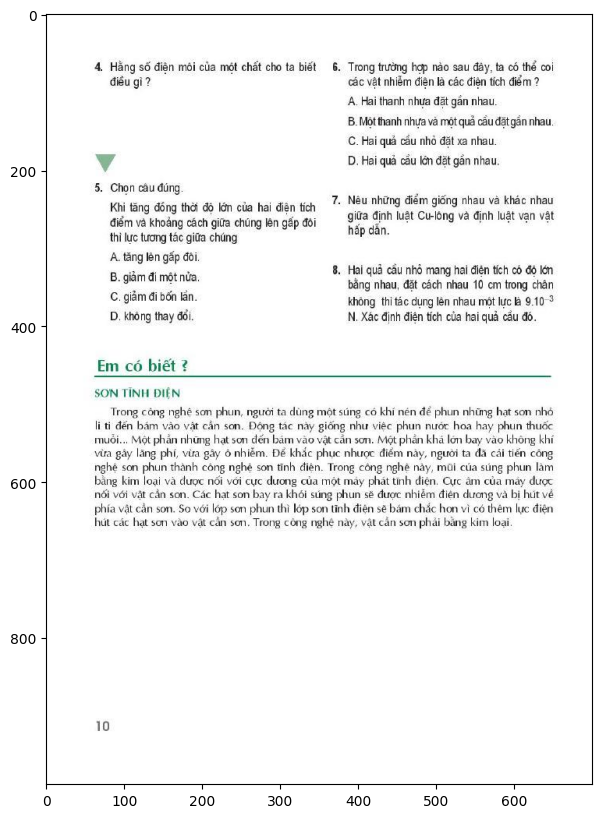

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


User: <image>
Câu hỏi 7 yêu cầu làm gì?
Assistant: Câu hỏi 7 yêu cầu nêu những điểm giống nhau và khác nhau giữa định luật Cu-lông và định luật vạn vật hấp dẫn.


In [9]:
test_image = "/kaggle/input/data-nlp-bai-2/img/img/100.jpg"
plt.figure(figsize=(10,10))
plt.imshow(Image.open(test_image))
plt.show()
pixel_values = load_image(test_image, max_num=6).to(torch.bfloat16).cuda()
generation_config = dict(max_new_tokens= 512, do_sample=False, num_beams = 3, repetition_penalty=3.5)

question = '<image>\nCâu hỏi 7 yêu cầu làm gì?'

response = model.chat(tokenizer, pixel_values, question, generation_config)
print(f'User: {question}\nAssistant: {response}')

In [10]:
response

'Câu hỏi 7 yêu cầu nêu những điểm giống nhau và khác nhau giữa định luật Cu-lông và định luật vạn vật hấp dẫn.'